# TP2 Robotica Movel

## Alunos
- Bernardo Nogueira Borges 2020006396
- Daniele Cassia Silva Diniz 2020076874


### Importando Libs

In [8]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import matplotlib.pyplot as plt
import numpy as np
import math

client = RemoteAPIClient()
sim = client.require('sim')
np.set_printoptions(precision=3,suppress=True)

### Obtendo Objetos de Interesse

In [9]:
# Objetos de interesse
objects = [
    ("robot","gray"),
    ("ice_cart","blue"),
    ("duck","orange"),
    ("tree","green"),
    ("lamp","yellow"),
    ("bench","red")
]

### 3 Definicao das Matrizes de Transformacoes Homogeneas

In [10]:
# Configuracao do robo no referencial global q = [x,y,theta]
robot = sim.getObject("/robot")

def getRobotQ():
    robotM = sim.getObjectMatrix(robot)
    return [robotM[3],robotM[7],math.atan2(robotM[1],robotM[0])]

q = getRobotQ()
print(f"q = {q}")

def matrix_rel_robot(name):
    obj = sim.getObject(f"/{name}")
    M = sim.getObjectMatrix(obj,robot)
    M = np.array(M).reshape(-1,4)
    return M

def plot_frame(M,label,color):
    Ps = M[0:2,3]
    xs = M[0:2,0]
    ys = M[0:2,1]
    # X & Y
    plt.quiver(*Ps, *xs, color=color, angles='xy', scale_units='xy', scale=1,label=label)
    plt.quiver(*Ps, *ys, color=color, angles='xy', scale_units='xy', scale=1)
    plt.legend()
    

q = [-3.919471788406371, -3.624998331069944, -0.523599898651281]


#### Plotando os referenciais

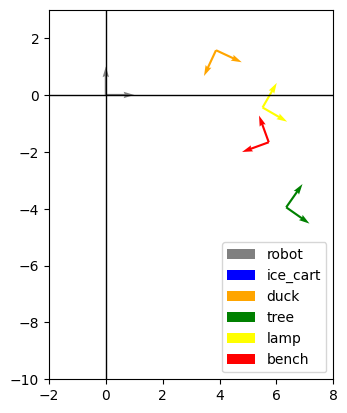

In [11]:

plt.figure()

for (name,color) in objects:
    M = matrix_rel_robot(name)
    plot_frame(M,name,color)


plt.axis('scaled')
plt.axis((-2,8,-10,3))

# Adding thick x and y axes
plt.axhline(0, color='black', linewidth=1.0)  # Horizontal line (Y axis)
plt.axvline(0, color='black', linewidth=1.0)  # Vertical line (X axis)
print()


### 5 Robo com Laser

In [12]:
def readSensorData():
    # ? Atualizacao da funcao simxGetStringSignal 
    string_range_data = sim.getStringSignal("hokuyo_range_data")
    string_angle_data = sim.getStringSignal("hokuyo_angle_data")

    # Verifica se os dados foram obtidos corretamente
    if string_range_data == None or string_angle_data == None: return None
    
    # unpack dos dados de range e angulos do sensor
    raw_range_data = sim.unpackFloatTable(string_range_data)
    raw_angle_data = sim.unpackFloatTable(string_angle_data)
    return raw_range_data, raw_angle_data


def draw_laser_data(laser_data,ax, max_sensor_range=5,show_robot=True):

    # Matriz de transformação laser -> robô
    Trl = matrix_rel_robot("fastHokuyo")
    Trl = np.vstack([Trl,[0,0,0,1]])

    # Matriz de transformação robô -> mundo
    Twr = sim.getObjectMatrix(robot)
    Twr = np.vstack([np.array(Twr).reshape(3,4),[0,0,0,1]])

 
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) < 0.1:
            continue

        x = dist * np.cos(ang)
        y = dist * np.sin(ang)

        if show_robot:
            c = 'b' if ang < 0 else 'r'
        else:
            c = 'g'
        
        # Ponto de leitura no referencial do laser
        Pl = np.array([x,y,0,1])
        # ponto laser -> robô
        Pr =  Trl @ Pl
        # ponto robô -> mundo
        Pw =  Twr @ Pr
        
        ax.plot(Pw[0], Pw[1], 'o', color=c)

    if show_robot:
        # Valores globais do Robo
        q = getRobotQ()

        # Plot do robô com referencial global
        ax.plot(q[0], q[1], marker=(3, 0, q[2]*90), markersize=20, linestyle='None', color='black')

    ax.grid()
    ax.set_xlim([-max_sensor_range, max_sensor_range])
    ax.set_ylim([-max_sensor_range, max_sensor_range])

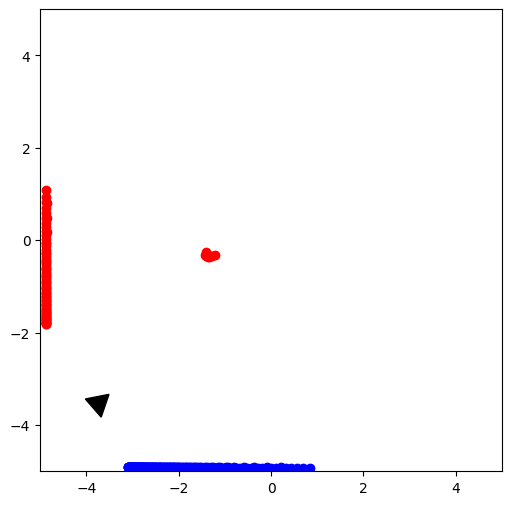

In [13]:
sim.startSimulation()
    
# Prosseguindo com as leituras
# Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
# Em loop até garantir que as leituras serão válidas
sensor_data = readSensorData()
while sensor_data == None:
    sensor_data = readSensorData()

raw_range_data, raw_angle_data = sensor_data
laser_data = np.array([raw_angle_data, raw_range_data]).T


fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_aspect('equal')
ax.grid()
draw_laser_data(laser_data,ax)

while (t := sim.getSimulationTime()) < 1:
    sim.step()

sim.stopSimulation()

### 6 Plot Incremental do Caminho Percorrido

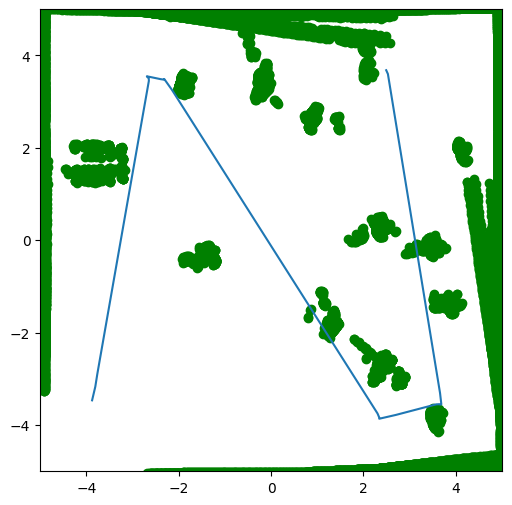

In [16]:
# Dados do Pioneer
L = 0.381   # Metros
r = 0.0975  # Metros
right_motor = sim.getObject("/robot/right_motor")
left_motor = sim.getObject("/robot/left_motor")

# Armazenando entre frames
lastTime = 0
robot_xs = []
robot_ys = []
    
# Definindo o plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_aspect('equal')
ax.grid()

# Inicio da simulacao
sim.startSimulation()

while (t := sim.getSimulationTime()) < 60:
    dt = t - lastTime

    # Fazendo leitura do laser
    sensor_data = readSensorData()
    while sensor_data == None: sensor_data = readSensorData()
    raw_range_data, raw_angle_data = sensor_data
    laser_data = np.array([raw_angle_data, raw_range_data]).T
    draw_laser_data(laser_data,ax,show_robot=False)

    # Velocidade básica (linear, angular)
    v = 0
    w = np.deg2rad(0)      

    front_side = int(len(laser_data)/2)
    right_side = int(len(laser_data)*1/4)
    left_side = int(len(laser_data)*3/4)
    
    if laser_data[front_side, 1] > 2:
        v = .5
        w = 0
    elif laser_data[right_side, 1] > 2:
        v = 0
        w = np.deg2rad(-30)
    elif laser_data[left_side, 1] > 2:
        v = 0
        w = np.deg2rad(30)
    
    # Isso é o modelo cinemático, estudaremos detalhadamente depois!
    wl = v/r - (w*L)/(2*r)
    wr = v/r + (w*L)/(2*r)

    # Enviando velocidades
    sim.setJointTargetVelocity(left_motor, wl)
    sim.setJointTargetVelocity(right_motor, wr)

    # Atualizando valores
    q = getRobotQ()
    robot_xs.append(q[0])
    robot_ys.append(q[1])
    lastTime = t
    sim.step()

# Plotando posicoes do robo
ax.plot(robot_xs,robot_ys)

# Parando o robô    
sim.setJointTargetVelocity(right_motor, 0)
sim.setJointTargetVelocity(left_motor, 0)
 
# Fim da simulacao
sim.stopSimulation()